In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from sklearn.preprocessing import OneHotEncoder
from qiskit.algorithms.optimizers import SPSA
import numpy as np
import itertools as itr
import matplotlib.pyplot as plt

DIR_val_train = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train = "Encode_data/amp_enc_data_set_trainning_classes.csv"

DIR_val_test = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test = "Encode_data/amp_enc_data_set_test_classes.csv"

# Circuito

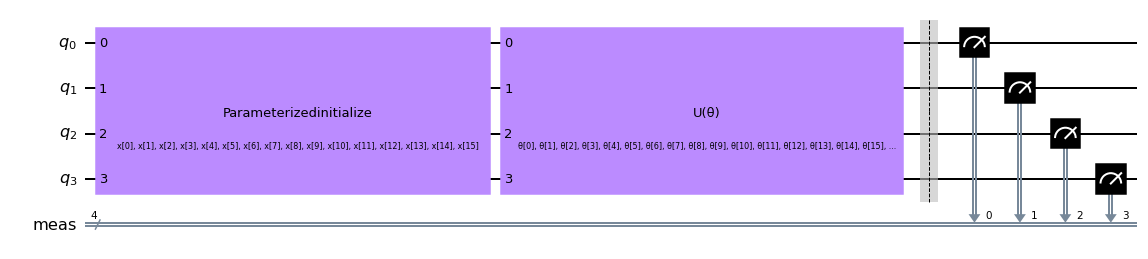

In [2]:
n_qubits = 4

encoding = RawFeatureVector(16)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=2, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")
ansatz.decompose()
qc = encoding.compose(ansatz)
qc.measure_all()

qc.draw(output="mpl")

In [3]:
def get_encode(file, type_ENC):

    """
    Funcao responsavel pelo encoding (amplitude)
    """
    if type_ENC.lower() == "amplitude":

        data_ENC = np.genfromtxt(file, delimiter=";")

    else:
        return None

    return data_ENC

In [4]:
train_data = get_encode(DIR_val_train, "amplitude")
train_labels = np.genfromtxt(DIR_cls_train, delimiter=";")

test_data = get_encode(DIR_val_test, "amplitude")
test_labels = np.genfromtxt(DIR_cls_test, delimiter=";")

In [5]:
def circuit_parameters(encoding, ansatz, x, thetas, self_encoding=False):
    parameters = {}
    if self_encoding:
        for i, p in enumerate(list(encoding.parameters)):
            parameters[p] = x[i]
    else:
        for i, p in enumerate(list(encoding.ordered_parameters)):
            parameters[p] = x[i]
    for i, p in enumerate(ansatz.ordered_parameters):
        parameters[p] = thetas[i]
    return parameters

In [6]:
def train(qc, encoding, ansatz, train_data, train_labels, self_encoding=False, lr=None, initial_point=None):
        # Callback function for optimiser for plotting purposes
        def store_intermediate_result(evaluation, parameter, cost, 
                                stepsize, accept):
                evaluations.append(evaluation)
                parameters.append(parameter)
                costs.append(cost)

        # Set up the optimization

        parameters = []
        costs = []
        evaluations = []

        if lr is not None:
                optimizer = SPSA(maxiter=100 , learning_rate=lr, callback=store_intermediate_result)
        else:
                optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

        if initial_point is not None:
                initial_point = initial_point
        else:      
                initial_point = np.random.random(ansatz.num_parameters)

        objective_function = lambda variational: cost_function(qc,encoding, ansatz,
                train_data, train_labels, variational, self_encoding=self_encoding)
        
        # Run the optimization
        opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

        return opt_var, opt_value , parameters, costs, evaluations 

In [7]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]
    #print(circuits)

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    prediction = [classification(results.get_counts(c)) for c in circuits]
    #print(prediction)
    #print(labels)
    #prediction = [0 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    for i, p in enumerate(prediction):
        #if (p and labels[i]) or (not p and not labels[i]):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

## Mean Square error

### Multi Qubit exp val

$$Cost() = \frac{1}{N}\sum (y-\hat{y})^2$$


In [ ]:
train_labels_oh = train_labels
test_labels_oh = test_labels

In [ ]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [classification(results.get_counts(c)) for c in circuits]
    #print(predictions)
    cost = np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(f"Cost {cost}")
    return cost

In [ ]:
#%%script echo skipping
def basis_states_probs(counts, shots=1024, decimal=False, n_qubits=1):
    
    """
    Retorna as probabilidades de cada estado
    """
    
    probs = []
   
    if decimal:
        basis_states = list(range(2**n_qubits))
    else:
        basis_states = [np.binary_repr(i,width=n_qubits) for i in range(2**n_qubits)]

    for b in basis_states:
        c = counts.get(b)
        if c is None:
            probs.append(0)
        else:
            probs.append(counts[b]/shots)
    
    return probs


def classification(counts, shots=1024, label=True):
    
    def count_ones(string):
        r = 0
        for char in string:
            if char == "1":
                r+=1
        return r
    
    def label_assign(exp_val):
        if exp_val >= 0:
            r = 1
        else:
            r = -1
        return r

    probs = basis_states_probs(counts, n_qubits=n_qubits)
    states = ["".join(seq) for seq in itr.product("01", repeat=n_qubits)]
    
    exp_val = 0
    for state, prob in zip(states, probs):
        #print(prob, state)
        exp_val += ((-1)**(count_ones(state)%2))*prob
    
    #print(f"Valor expectávlel {exp_val}, Label {label_assign(exp_val)} ")
    if label:
        return label_assign(exp_val)
    else:
        return exp_val
    
def loss_function(y,y_hat):
    #print(f"Loss {y}-{y_hat}**2")
    #print(f"Loss {(y-y_hat)**2}")
    return (y-y_hat)**2

In [ ]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

In [ ]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [ ]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

## Cross Entropy Loss

### Parity method

In [8]:
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

In [9]:
def parity_classification(counts, shots=1024):
    probs = np.zeros(2)
    for bitstring, counts in counts.items():
        hw_parity = hamming_weight_parity(bitstring)
        probs[hw_parity] += counts/shots
    
    return probs
def hamming_weight_parity(bitstring):
    hamming_weight = sum([int(k) for k in bitstring])
    return hamming_weight % 2

def loss_function(y,y_hat):
    #print(y_hat)
    return np.sum(y*np.log(y_hat))

In [10]:
def cost_function(qc, encoding, ansatz, X, Y, thetas, self_encoding=False):
    #thetas -> variational parameters
    #X dataset
    #Y labels

    #build circuits for each datapoint
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in X]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    predictions = [parity_classification(results.get_counts(c)) for c in circuits]

    cost = -np.mean(np.array([loss_function(y,y_hat) for (y,y_hat) in zip(Y, predictions)]))
    print(cost)
    return cost

In [11]:
opt_var, opt_value , parameters, costs, evaluations = train(qc, encoding, ansatz, train_data, train_labels_oh, self_encoding=True)

0.7039002331126141
0.646056552351915
0.6730772871882157
0.7518490059575595
0.7096151974351295
0.7235302787605787
0.6884630485350761
0.6843059583921002
0.7183842631951538
0.6318601843236171
0.7137382321046077
0.7355142245195057
0.7338860153331178
0.7905423379662705
0.7428445772513438
0.6880829847780259
0.6161627867680919
0.7640266349574638
0.63105503397702
0.6761117809617618
0.6924847599070139
0.7656313096764382
0.8112927683911965
0.7151507393880385
0.7493614672446345
0.7874356252209046
0.6910511695156188
0.6433288733090385
0.6693771263691927
0.7253846958204624
0.6727755788673917
0.669361970875605
0.7388398614663864
0.6709822248140836
0.6758681114194597
0.7307123885200946
0.6745205138207786
0.716140645196865
0.6665845949052864
0.7727772666872177
0.694422503743434
0.7178457476376896
0.7064167924683293
0.7148925321101858
0.6681318314117359
0.6993135863612079
0.756886196768028
0.6313258888504868
0.7015210218632905
0.7186540841870055
0.6518336427374856
0.7215575506273203
0.6233252679454744


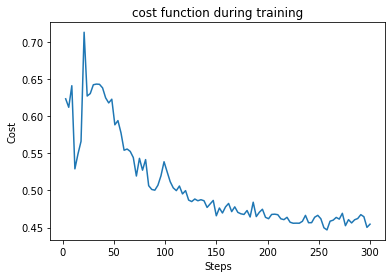

In [12]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel("Steps")
plt.ylabel("Cost")
plt.title("cost function during training")
plt.show()

In [27]:
def func_accuracy(data, labels, thetas, self_encoding=False):
    circuits = [qc.assign_parameters(circuit_parameters(encoding, ansatz, x, thetas, self_encoding=self_encoding)) for x in data]

    backend = Aer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    probs = [parity_classification(results.get_counts(c)) for c in circuits]
    print(probs)
    prediction = [-1 if p[0] > p[1] else 1 for p in probs]
    accuracy = 0
    print(labels)
    print(prediction)
    for i, p in enumerate(prediction):
        if p == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [28]:
accuracy, prediction = func_accuracy(test_data, test_labels, opt_var, self_encoding=True)
print("Test set accuracy - {}".format(accuracy))

[array([0.54296875, 0.45703125]), array([0.68554688, 0.31445312]), array([0.57226562, 0.42773438]), array([0.38476562, 0.61523438]), array([0.65722656, 0.34277344]), array([0.06347656, 0.93652344])]
[ 1. -1. -1.  1. -1.  1.]
[-1, -1, -1, 1, -1, 1]
Test set accuracy - 0.8333333333333334


In [29]:
print(opt_var)

[ 0.00827305  0.66909004  0.19058844  1.07056268  2.69965721 -0.03340046
 -0.12271985 -0.17804754  0.56167108  2.13574834 -0.18442499 -1.24208513
 -1.14120562  1.58932244  2.04472611  2.5297723  -0.2380257  -1.26519356
  0.21004743  0.75513059  0.02544572  0.36393005 -0.13091016  1.83590685]
